## **Access Data and Fetch from API:**


## Setting Up a Spotify App to Access Data

### Create a Spotify Developer Account

- **Sign In**: Log in to the [Spotify Developer Dashboard](https://developer.spotify.com/dashboard/).
- **Create an App**: Provide an app name and description. You will receive a Client ID and Client Secret.

### Set Up Authorization

Use the `SpotifyOAuth` class for authorization. Define the necessary scopes based on the data you need access to.

```python
import spotipy
from spotipy.oauth2 import SpotifyOAuth

CLIENT_ID = 'your-client-id'
CLIENT_SECRET = 'your-client-secret'
REDIRECT_URI = 'http://your-redirect-uri'

scopes = ["user-read-playback-state", "playlist-read-private"]
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=CLIENT_ID,
                                               client_secret=CLIENT_SECRET,
                                               redirect_uri=REDIRECT_URI,
                                               scope=",".join(scopes)))
```

Replace `'your-client-id'`, `'your-client-secret'`, and `'http://your-redirect-uri'` with your actual details.

### Access Spotify Data

After authorization, you can make API calls to retrieve data. For example, to get the current user's profile:

```python
user_data = sp.current_user()
print('Name:', user_data['display_name'])
print('Followers:', user_data['followers']['total'])
```

For more detailed guidance, refer to the [Spotify Web API documentation](https://developer.spotify.com/documentation/web-api/).


In [ ]:
# !pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.8/251.8 kB 38.2 kB/s eta 0:00:00a 0:00:01
  Using cached async_timeout-4.0.3-py3-none-any.whl (5.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import json
import numpy as np
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
from time import sleep


In [2]:
# Load environment variables
load_dotenv()
API_USERNAME="c1041f2825614709a07e366170dfca6f"
API_KEY="5ac1059805b045268329de0692a7aa0d"
REDIRECT_URI="http://localhost:8080"

In [3]:
# Spotify client setup
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=API_USERNAME,
    client_secret=API_KEY,
    redirect_uri=REDIRECT_URI
))

Unzip the Challenge Data Json

In [4]:
!unzip dataset.zip

In [5]:
def read_dataset(filename):
    """Reads the JSON dataset from a file."""
    with open(filename, "r") as file:
        return json.load(file)

def extract_track_uris(data_set):
    """Extracts unique track URIs from the dataset."""
    track_uris = set()
    for playlist in data_set["playlists"]:
        if len(playlist["tracks"]) == 100:
            for track in playlist["tracks"]:
                track_uris.add((track["track_name"], track["artist_name"], track["track_uri"]))
    return list(track_uris)

def fetch_audio_features(tracks, chunk_size=100, retry_failed=False):
    """Fetch audio features for tracks and handle failures."""
    chunks = np.arange(0, len(tracks), chunk_size)
    failed_chunks = []
    for chunk in chunks:
        print(f"Processing chunk {chunk} out of {chunks[-1]}")
        current_tracks = tracks[chunk:chunk + chunk_size]
        request_ids = [track[2] for track in current_tracks]

        try:
            resp = sp.audio_features(request_ids)
            df = pd.DataFrame([x for x in resp if x is not None])
            df.to_csv(f"./fetched_chunks/{chunk}_{chunk + chunk_size}.csv")
        except Exception as e:
            print(f"Failed to process chunk {chunk}: {e}")
            failed_chunks.append((chunk, chunk + chunk_size))
            with open("failures.txt", "a") as f:
                f.write(f"Failed chunk {chunk}:{chunk + chunk_size}\n")
        finally:
            sleep(2)
    
    if retry_failed:
        for chunk_start, chunk_end in failed_chunks:
            retry_fetching(chunk_start, chunk_end)

def retry_fetching(chunk_start, chunk_end):
    """Retries fetching audio features for failed chunks."""
    tracks = track_uris[chunk_start:chunk_end]
    request_ids = [track[2] for track in tracks]
    try:
        resp = sp.audio_features(request_ids)
        df = pd.DataFrame([x for x in resp if x is not None])
        df.to_csv(f"./fetched_chunks/{chunk_start}_{chunk_end}.csv")
    except Exception as e:
        print(f"Permanent failure for chunk {chunk_start} to {chunk_end}: {e}")

def consolidate_data(output_filename):
    """Consolidates all CSV files into a single DataFrame."""
    all_files = [f for f in os.listdir("./fetched_chunks") if f.endswith(".csv")]
    df_list = [pd.read_csv(f"./fetched_chunks/{filename}") for filename in all_files]
    final_df = pd.concat(df_list, ignore_index=True)
    final_df.to_csv(output_filename, index=False)
    return final_df

In [6]:
# Main execution flow
data_set = read_dataset("challenge_set.json")

In [7]:
track_uris = extract_track_uris(data_set)

In [8]:
fetch_audio_features(track_uris, retry_failed=True)

Processing chunk 0 out of 53500
Processing chunk 100 out of 53500
Processing chunk 200 out of 53500
Processing chunk 300 out of 53500
Processing chunk 400 out of 53500
Processing chunk 500 out of 53500
Processing chunk 600 out of 53500
Processing chunk 700 out of 53500
Processing chunk 800 out of 53500
Processing chunk 900 out of 53500
Processing chunk 1000 out of 53500
Processing chunk 1100 out of 53500
Processing chunk 1200 out of 53500
Processing chunk 1300 out of 53500
Processing chunk 1400 out of 53500
Processing chunk 1500 out of 53500
Processing chunk 1600 out of 53500
Processing chunk 1700 out of 53500
Processing chunk 1800 out of 53500
Processing chunk 1900 out of 53500
Processing chunk 2000 out of 53500
Processing chunk 2100 out of 53500
Processing chunk 2200 out of 53500
Processing chunk 2300 out of 53500
Processing chunk 2400 out of 53500
Processing chunk 2500 out of 53500
Processing chunk 2600 out of 53500
Processing chunk 2700 out of 53500
Processing chunk 2800 out of 535

In [12]:
final_df = consolidate_data("all_downloaded_data.csv")

In [13]:
final_df.drop("Unnamed: 0", axis=1, inplace=True)

In [14]:
final_df.to_csv('all_downloaded_data.csv', index=False)

### **Data Analysis**

In [15]:
import numpy as np
import pandas as pd
import json
import os
from scipy.sparse import csr_matrix

In [18]:
#helper functions
def load_json_data(filename):
    """Load and return JSON data from a file."""
    with open(filename, 'r') as file:
        return json.load(file)

def extract_unique_tracks(data_set):
    """Extract unique tracks from the data set."""
    track_uris = set()
    for playlist in data_set["playlists"]:
        if len(playlist["tracks"]) == 100:
            for track in playlist["tracks"]:
                track_uris.add((track["track_name"], track["artist_name"], track["track_uri"]))
    return list(track_uris)

def create_uri_to_title_artist_map(tracks):
    """Map URIs to title and artist names."""
    return {track[2]: (track[0], track[1]) for track in tracks}

def load_audio_features(filename):
    """Load audio feature data into a DataFrame."""
    df = pd.read_csv(filename)
    # df.drop(columns="Unnamed: 0", inplace=True)
    return df.set_index('uri')

def build_playlist_membership_matrix(tracks, data_set):
    """Build a matrix of playlist memberships for each track."""
    playlist_idcs = [i for i, p in enumerate(data_set["playlists"]) if len(p["tracks"]) == 100]
    unique_tracks = {track[2]: idx for idx, track in enumerate(tracks)}
    matrix = np.zeros((len(tracks), len(playlist_idcs)), dtype="u1")

    for idx, playlist in enumerate(playlist_idcs):
        track_uris = [track["track_uri"] for track in data_set["playlists"][playlist]["tracks"]]
        for uri in track_uris:
            if uri in unique_tracks:
                matrix[unique_tracks[uri], idx] = 1
    
    return matrix, playlist_idcs

def compute_song_frequencies(matrix):
    """Compute the frequency of two songs appearing in the same playlist using a sparse matrix."""
    csr_matrix_form = csr_matrix(matrix)
    frequency_matrix = csr_matrix_form @ csr_matrix_form.T
    return frequency_matrix

def find_most_common_songs(frequency_matrix, track_labels):
    """Identify the two songs with the highest pairwise playlist count."""
    dense_matrix = frequency_matrix.todense()
    np.fill_diagonal(dense_matrix, 0)
    max_indices = np.unravel_index(dense_matrix.argmax(), dense_matrix.shape)
    return max_indices, dense_matrix[max_indices], track_labels

In [19]:
# Main script execution
data_set = load_json_data("challenge_set.json")
unique_tracks = extract_unique_tracks(data_set)
uri_to_title_artist_map = create_uri_to_title_artist_map(unique_tracks)
df = load_audio_features("all_downloaded_data.csv")

membership_mtx, playlist_idcs = build_playlist_membership_matrix(unique_tracks, data_set)
np.save("playlist_membership_data.npy", membership_mtx)
np.save("playlist_membership_labels.npy", unique_tracks)

In [20]:
# Reload matrix if needed
membership_mtx = np.load("playlist_membership_data.npy")
unique_tracks = np.load("playlist_membership_labels.npy")

frequency_csr_mtx = compute_song_frequencies(membership_mtx)
max_elem, count, track_labels = find_most_common_songs(frequency_csr_mtx, unique_tracks)

print("The most commonly associated songs are:")
print(f"\t {track_labels[max_elem[0]][0]} by {track_labels[max_elem[0]][1]}")
print(f"\t {track_labels[max_elem[1]][0]} by {track_labels[max_elem[1]][1]}")
print(f"Appeared in the same playlist {count}/2000 times")

The most commonly associated songs are:
	 Broccoli (feat. Lil Yachty) by DRAM
	 Caroline by Aminé
Appeared in the same playlist 57/2000 times


## **Cluster Analysis**

In [21]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px
import scipy.cluster.hierarchy as shc
import os

In [22]:
# Load JSON Data
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Extract unique tracks from dataset
def get_unique_tracks(data):
    track_uris = set()
    for playlist in data["playlists"]:
        if len(playlist["tracks"]) == 100:
            track_uris.update((track["track_name"], track["artist_name"], track["track_uri"]) for track in playlist["tracks"])
    return list(track_uris)

In [23]:
data_set = load_data("challenge_set.json")
unique_tracks = get_unique_tracks(data_set)
uri_to_title_artist_map = {uri: (name, artist) for name, artist, uri in unique_tracks}

In [24]:
# Load dataset
df = pd.read_csv("all_downloaded_data.csv")
# df.drop(columns=["Unnamed: 0"], inplace=True)
df.set_index('uri', inplace=True)
df = df.iloc[:, :10]  # Select only the first 10 features
df.drop_duplicates(inplace=True)

# Split into training and testing datasets
train, test = df[:40000], df[40000:]

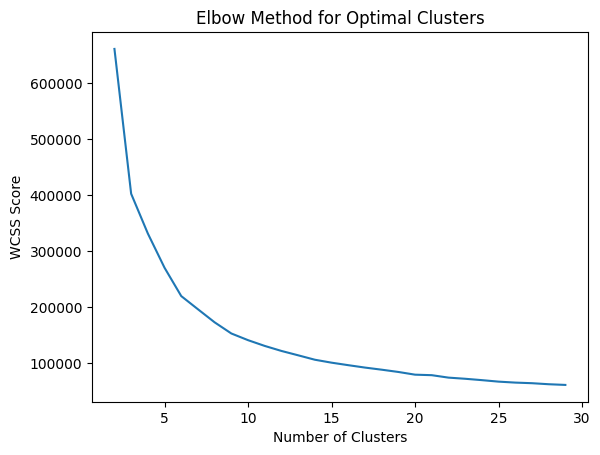

In [25]:
# Finding optimal number of clusters using the elbow method
def determine_optimal_clusters(data):
    scores = []
    cluster_range = range(2, 30)
    for k in cluster_range:
        kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300)
        kmeans.fit(data)
        scores.append(kmeans.inertia_)
    plt.plot(cluster_range, scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS Score')
    plt.title('Elbow Method for Optimal Clusters')
    plt.show()

determine_optimal_clusters(train)

**KNN Clustering**

In [28]:
# Build and train KMeans model
kmeans = KMeans(init="random", n_clusters=13, n_init=10, max_iter=300, random_state=1)
model = kmeans.fit(train)

# Predict clusters on the testing set
predictions = model.predict(test)

In [29]:
# Visualizing results with TSNE
def visualize_clusters(data, predictions):
    tsne = TSNE(n_components=2, random_state=1)
    transformed_data = tsne.fit_transform(data)
    projection = pd.DataFrame(transformed_data, columns=['x', 'y'], index=data.index)
    projection['cluster'] = predictions
    
    # Merge original data for hover information
    hover_data = data.copy()
    hover_data['x'] = projection['x']
    hover_data['y'] = projection['y']
    hover_data['cluster'] = projection['cluster']
    
    # Create the scatter plot using Plotly Express
    fig = px.scatter(hover_data, x='x', y='y', color='cluster', hover_data=data.columns.tolist())
    fig.update_layout(title="TSNE Projection of Clusters", xaxis_title="TSNE-1", yaxis_title="TSNE-2")
    fig.show()

visualize_clusters(test, predictions)

/Users/macbook/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/macbook/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


**Recommender System**

In [32]:
# Helper functions for recommendation system
def get_uri(track_name, artist_name):
    return next((uri for uri, (name, artist) in uri_to_title_artist_map.items() if name == track_name and artist == artist_name), None)

def recommend_song(track_name, artist_name):
    uri = get_uri(track_name, artist_name)
    if uri:
        # Fetch the track features in the correct format
        track_features = df.loc[uri].values.reshape(1, -1)
        
        # Predict the cluster for the given song
        cluster_label = model.predict(track_features)[0]
        
        # Find indices where the cluster label matches
        similar_indices = [i for i, pred in enumerate(predictions) if pred == cluster_label]
        
        # Fetch similar tracks from the test dataset using indices
        similar_tracks_uris = test.iloc[similar_indices].index
        
        # Prepare list of recommended songs
        recommended_songs = [uri_to_title_artist_map[track_uri] for track_uri in similar_tracks_uris[:10]]
        return recommended_songs
    else:
        return []

In [33]:
song_title, song_artist = 'Brand New Key', 'Melanie'
print(f"Based on our clustering model and the inputted song: {song_title} by {song_artist}")
recommended_songs = recommend_song(song_title, song_artist)
print("We recommend the following songs:")
for song in recommended_songs:
    print(f"{song[0]} by {song[1]}")

Based on our clustering model and the inputted song: Brand New Key by Melanie
We recommend the following songs:
Ich wollt, ich wär ein Huhn - From "Inglourious Basterds" by Lilian Harvey
The Walk by Sawyer Brown
Momma Tried by Merle Haggard
Yeah Right by Vince Staples
1957 by Milo Greene
Lucy In The Sky With Diamonds - LOVE Version by The Beatles
30,000 Feet by Ben Rector
Everything Changes by Judah & the Lion
Holly Roller by AWOLNATION
O Holy Night by Andy Williams


/Users/macbook/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



In [34]:
# Hierarchical clustering to create dendrograms
plt.figure(figsize=(18, 7))
plt.title("Track Dendrogram")
dendrogram = shc.dendrogram(shc.linkage(train, method='ward'))